In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms

In [3]:
Data = []
Label = []

pad1d = lambda a,i : a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a,i : a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i - a.shape[1]))))

In [4]:
DATA_DIR = 'C:/Users/ADmin/Desktop/train/audio/'
num = {'zero/' : 0,'one/' : 1,'two/' : 2,'three/' : 3,'four/' : 4,'five/' : 5,'six/' : 6,'seven/' : 7,'eight/' : 8,'nine/' : 9}

for n_folder,n in num.items():
    for fname in os.listdir(DATA_DIR + n_folder):
        wav, _ = librosa.load(DATA_DIR + n_folder + fname)

        Data.append(wav)
        Label.append(n)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, Label, test_size = 0.2,random_state = 123, shuffle = True, stratify = Label)

In [14]:
train_X = []
train_mfccs = []
train_y = []

#STFT한것, CNN분석하기 위해 Spectrogram으로 만든 것, MF한것, mel-spectorgram한것

for i in range(len(X_train)):
    wav = X_train[i]
    label = y_train[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,40)

    train_X.append(padded_x)
    train_mfccs.append(padded_mfcc) 
    train_y.append(label)

valid_X = []
valid_mfccs = []
valid_y = []

for i in range(len(X_valid)):
    wav = X_valid[i]
    label = y_valid[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,40)

    valid_X.append(padded_x)
    valid_mfccs.append(padded_mfcc) 
    valid_y.append(label)

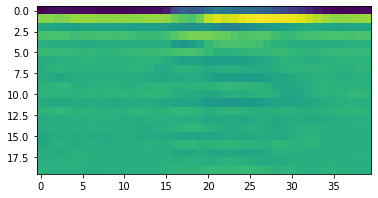

In [23]:
#train_mfccs = torch.FloatTensor(train_mfccs)
#plt.imshow(train_mfccs[65,:,:])

In [8]:
train_X = torch.FloatTensor(train_X)
train_mfccs = torch.FloatTensor(train_mfccs)
train_y = torch.LongTensor(train_y)

train_mfccs = train_mfccs.unsqueeze(1)

valid_X = torch.FloatTensor(valid_X)
valid_mfccs = torch.FloatTensor(valid_mfccs)
valid_y = torch.LongTensor(valid_y)

valid_mfccs = valid_mfccs.unsqueeze(1)

print('train_X: ', train_X.shape)
print('train_mfccs: ', train_mfccs.shape)
print('train_y: ', train_y.shape)
print('----------------------------------')
print("valid_X: ", valid_X.shape)
print("valid_mfccs: ", valid_mfccs.shape)
print("valid_y: ", valid_y.shape)

train_X:  torch.Size([18932, 30000])
train_mfccs:  torch.Size([18932, 1, 20, 40])
train_y:  torch.Size([18932])
----------------------------------
valid_X:  torch.Size([4734, 30000])
valid_mfccs:  torch.Size([4734, 1, 20, 40])
valid_y:  torch.Size([4734])


In [9]:
train_data = TensorDataset(train_mfccs, train_y)
train_data = DataLoader(train_data, batch_size=240, drop_last=False, shuffle=True)

valid_data = TensorDataset(valid_mfccs, valid_y)
valid_data = DataLoader(valid_data, batch_size=60, drop_last=False, shuffle=True)

In [10]:
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 64, 4) # 1@20*40 -> 64@17*37
        # activation ReLU
        pool1 = nn.MaxPool2d(2,2) # 64@8*18
        conv2 = nn.Conv2d(64, 128, 4) # 128@5*15
        # activation ReLU
        pool2 = nn.MaxPool2d(2,2) # 128@2*7
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(128*2*7, 64)
        # activation ReLU
        fc2 = nn.Linear(64, 32)
        # activation ReLU
        fc3 = nn.Linear(32, 10)
        
        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @128*254*7
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [11]:
cnn = CNNClassifier()
print(cnn)

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Linear(in_features=1792, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [11]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 0.0005 #1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 100
num_batches = len(train_data)

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

train_total = 0
train_correct = 0
train_incorrect = 0
valid_total = 0
valid_correct = 0
valid_incorrect = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    for i, data in enumerate(train_data):
        x, label = data

        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        train_loss += loss.item()
        # del (memory issue)
        del loss
        
        for ix in range(len(model_output)):
            if torch.argmax(model_output[ix]).item() == label[ix].item():
                train_correct += 1
            else:
                train_incorrect += 1
        
        # 학습과정 출력
        if (i+1) % 70 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                valid_loss = 0.0
                for j, valid in enumerate(valid_data):
                    valid_x, valid_label = valid
                    if use_cuda:
                        valid_x = valid_x.cuda()
                        valid_label = valid_label.cuda()
                    valid_output = cnn(valid_x)
                    v_loss = criterion(valid_output, valid_label)
                    valid_loss += v_loss
                    
                    for idx in range(len(valid_output)):
                        if torch.argmax(valid_output[idx]).item() == valid_label[idx].item():
                            valid_correct += 1
                        else:
                            valid_incorrect += 1                  

            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss, valid_loss
            ))            
            
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_loss = 0.0
    train_accuracy.append((train_correct/(train_correct+train_incorrect))*100)
    valid_accuracy.append((valid_correct/(valid_correct+valid_incorrect))*100)

print('Accuracy of the network on the train audio: %f %%' % (train_accuracy[-1]))
print('Accuracy of the network on the test audio: %f %%' % (valid_accuracy[-1]))

epoch: 1/100 | step: 70/79 | trn loss: 138.1544 | val loss: 139.9441
epoch: 2/100 | step: 70/79 | trn loss: 121.4550 | val loss: 136.5791
epoch: 3/100 | step: 70/79 | trn loss: 115.5288 | val loss: 130.5961
epoch: 4/100 | step: 70/79 | trn loss: 112.7864 | val loss: 124.7634
epoch: 5/100 | step: 70/79 | trn loss: 107.7866 | val loss: 124.1713
epoch: 6/100 | step: 70/79 | trn loss: 107.3948 | val loss: 122.8808
epoch: 7/100 | step: 70/79 | trn loss: 106.5644 | val loss: 122.3570
epoch: 8/100 | step: 70/79 | trn loss: 106.1139 | val loss: 122.0702
epoch: 9/100 | step: 70/79 | trn loss: 105.7470 | val loss: 121.5154
epoch: 10/100 | step: 70/79 | trn loss: 105.5377 | val loss: 121.9352
epoch: 11/100 | step: 70/79 | trn loss: 105.1562 | val loss: 122.1691
epoch: 12/100 | step: 70/79 | trn loss: 105.1178 | val loss: 122.2349
epoch: 13/100 | step: 70/79 | trn loss: 105.1274 | val loss: 121.1641
epoch: 14/100 | step: 70/79 | trn loss: 104.5330 | val loss: 121.5143
epoch: 15/100 | step: 70/79 |

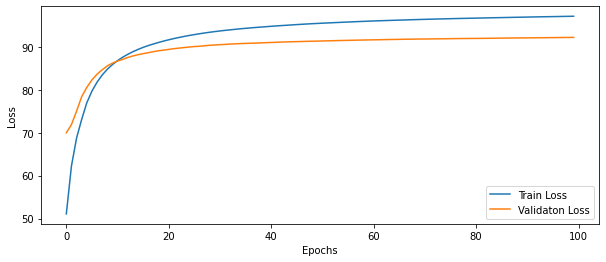

In [12]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(train_accuracy, label = 'Train Loss')
plt.plot(valid_accuracy, label = 'Validaton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:
TEST_DATA_DIR = 'C:/Users/ADmin/Desktop/닭/'
TEST_Data = []

for fname in os.listdir(TEST_DATA_DIR):
    wav, _ = librosa.load(TEST_DATA_DIR + fname)

    TEST_Data.append(wav)

In [14]:
os.listdir(TEST_DATA_DIR)

['eight_1.wav',
 'eight_2.wav',
 'five_1.wav',
 'five_2.wav',
 'four_1.wav',
 'four_2.wav',
 'nine_1.wav',
 'nine_2.wav',
 'one_1.wav',
 'one_2.wav',
 'seven_1.wav',
 'seven_2.wav',
 'six_1.wav',
 'six_2.wav',
 'three_1.wav',
 'three_2.wav',
 'two_1.wav',
 'two_2.wav',
 'zero_1.wav',
 'zero_2.wav']

In [48]:
TEST_padded_mfcc = []
for i in range(len(TEST_Data)):
    TEST_mfcc = librosa.feature.mfcc(TEST_Data[i])
    TEST_padded_mfcc.append(pad2d(TEST_mfcc,40)) 
    
TEST_padded_mfcc = torch.cuda.FloatTensor(TEST_padded_mfcc)
TEST_mfcc = TEST_padded_mfcc.unsqueeze(1)

TEST_pred = cnn(TEST_mfcc)

torch.argmax(TEST_pred,axis=1)

tensor([6, 8, 5, 3, 4, 4, 9, 9, 1, 1, 7, 7, 6, 6, 3, 3, 2, 2, 0, 2],
       device='cuda:0')

In [49]:
max_ind = []
second_ind = []

for ind in range(len(TEST_pred)):
    max_i = torch.argmax(TEST_pred[ind])
    TEST_pred[ind][max_i] = 0
    
    max_ind.append(max_i)
    second_ind.append(torch.argmax(TEST_pred[ind]))

In [54]:
for i in range(len(max_ind)):
    print(os.listdir(TEST_DATA_DIR)[i],"//",max_ind[i].item(),"//", second_ind[i].item())

eight_1.wav // 6 // 2
eight_2.wav // 8 // 2
five_1.wav // 5 // 1
five_2.wav // 3 // 7
four_1.wav // 4 // 5
four_2.wav // 4 // 3
nine_1.wav // 9 // 1
nine_2.wav // 9 // 7
one_1.wav // 1 // 5
one_2.wav // 1 // 5
seven_1.wav // 7 // 2
seven_2.wav // 7 // 0
six_1.wav // 6 // 2
six_2.wav // 6 // 7
three_1.wav // 3 // 5
three_2.wav // 3 // 7
two_1.wav // 2 // 7
two_2.wav // 2 // 0
zero_1.wav // 0 // 2
zero_2.wav // 2 // 6
